# ML Rank Histograms

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["image.origin"] = "lower"


Input a file path

In [2]:
source_paths = ["/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_12_26",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_14_15",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_17_09",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_55_23",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T13_30_38",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T14_24_40"]

See the files in the directory

The different job result follow the output structure:
- Folders `0`, `1`, `6`, `12`, `24`, `27` for the different hours after spin-up
- Files `<n>_MLvalue_<l>.npy` where `n` is the experiment number and `l` is the level index (for higher levels it is succeeded by `_0` or `_1`)

In [3]:
fcount = 0
for f in os.listdir(os.path.join(source_paths[0], "0")):
    if f.startswith("0_"):
        fcount += 1

l_max = int((fcount-1)/2)

The data in the files has the shape $3 \times 24 \times N_e^l$ for all 3 variables and for all 24 locations 

Rank Histogram Utils

In [4]:
def loadMLvalues(source_path, T, n):
    MLvalues = []
    MLvalues.append(np.load(source_path+"/"+str(T)+"/"+str(n)+"_MLvalues_0.npy"))
    for l_idx in range(1, l_max+1):
        MLvalues.append([np.load(source_path+"/"+str(T)+"/"+str(n)+"_MLvalues_"+str(l_idx)+"_0.npy"),
                            np.load(source_path+"/"+str(T)+"/"+str(n)+"_MLvalues_"+str(l_idx)+"_1.npy")])
    return MLvalues

In [5]:
def loadTruth(source_path, T, n):
    return np.load(source_path+"/"+str(T)+"/"+str(n)+"_TRUEvalues.npy")

In [6]:
def resample(MLensemble, newN, obs_idxs):
    newEnsemble = np.zeros(newN)

    ML_Ne = np.zeros(len(MLensemble))
    ML_Ne[0] = MLensemble[0].shape[-1]
    for l_idx in range(1, len(MLensemble)):
        ML_Ne[l_idx] = MLensemble[l_idx][0].shape[-1]

    for n in range(newN):
        u = np.random.uniform(0,1)
        newX = np.sort(MLensemble[0][obs_idxs[0]])[np.ceil(ML_Ne[0]*u).astype(int)-1] 
        for l_idx in range(1, len(ls)):
            newX += np.sort(MLensemble[l_idx][0][obs_idxs[l_idx]])[np.ceil(ML_Ne[l_idx]*u).astype(int)-1] - np.sort(MLensemble[l_idx][1][obs_idxs[l_idx]])[np.ceil(ML_Ne[l_idx]*u).astype(int)-1]
        newEnsemble[n] = newX
    
    return newEnsemble

In [7]:
def resample(ensemble_values, resampleN):
    resample_values = np.zeros((3,24,resampleN))

    ML_Ne = np.zeros(len(ensemble_values))
    ML_Ne[0] = ensemble_values[0].shape[-1]
    for l_idx in range(1, len(ensemble_values)):
        ML_Ne[l_idx] = ensemble_values[l_idx][0].shape[-1]

    for j in range(24):
        for n in range(resampleN):
            u = np.random.uniform(0,1)
            for i in range(3):
                newX = np.sort(ensemble_values[0][i,j])[np.ceil(ML_Ne[0]*u).astype(int)-1] 
                for l_idx in range(1, len(ML_Ne)):
                    newX += np.sort(ensemble_values[l_idx][0][i,j])[np.ceil(ML_Ne[l_idx]*u).astype(int)-1] - np.sort(ensemble_values[l_idx][1][i,j])[np.ceil(ML_Ne[l_idx]*u).astype(int)-1]
                resample_values[i,j,n] = newX
    
    return resample_values

In [8]:
def SLrank(ensemble_values, true_values):
    ML_Fy = 1/(ensemble_values.shape[-1])*np.sum(1*(ensemble_values < true_values[:,:,np.newaxis]), axis=-1)
    return ML_Fy

In [9]:
def MLranks4T(T):
    ranks = np.array([]).reshape(0,3)
    for p in range(len(source_paths)):
        for n in range(50):
            try: 
                MLensemble = loadMLvalues(source_paths[p], T, n)
                MLresample = resample(MLensemble, 1000)
                truth = loadTruth(source_paths[p], T, n)
                
                ranks = np.vstack([ranks, SLrank(MLresample, truth).T]) 
            except:
                pass
    
    return ranks

In [10]:
MLranks = MLranks4T(27)

In [11]:
c0 = (0, 68/255, 136/255)

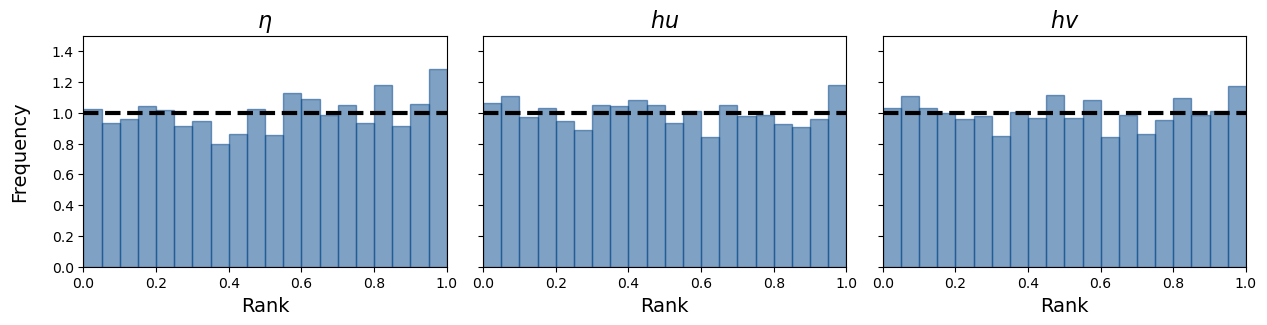

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15,3), sharey=True, gridspec_kw={'wspace': 0.1})

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].yaxis.set_label_coords(-.15, .5)

xlim = (0.0,1.0)
bins_size = 0.05
bins = np.arange(xlim[0],xlim[1]+1e-9, bins_size)

for i in range(3):
    ranks = np.maximum(xlim[0], MLranks[:,i])
    ranks = np.minimum(ranks, xlim[1])
    hist = np.histogram(ranks, bins=bins)
    
    axs[i].bar(0.5*(hist[1][1:]+hist[1][:-1]), hist[0]/len(MLranks[:,i])/bins_size, 
               width=bins_size, 
               color=c0, alpha=0.5, edgecolor=c0)
    
    axs[i].set_ylim((0,1.5))
    axs[i].set_xlim(xlim)

    axs[i].plot([0,1],[1,1], color="black", ls="--", lw=3)

    axs[i].set_xlabel('Rank', fontsize=14)

plt.savefig("DoubleJet-MLRanks-PostProcessing4paperNEW.pdf", bbox_inches="tight", dpi=300)